# Classification

Machine learning models rely on optimizing an objective function, by seeking
its minimum or maximum. It is important to understand that this objective
function is usually decoupled from the evaluation metric that we want to
optimize in practice. The objective function serves as a proxy for the
evaluation metric. Therefore, in the upcoming notebooks, we will present
the different evaluation metrics used in machine learning.

This notebook aims at giving an overview of the classification metrics that
can be used to evaluate the predictive model generalization performance. We can
recall that in a classification setting, the vector `target` is categorical
rather than continuous.

We will load the blood transfusion dataset.

In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

Let's start by checking the classes present in the target vector `target`.

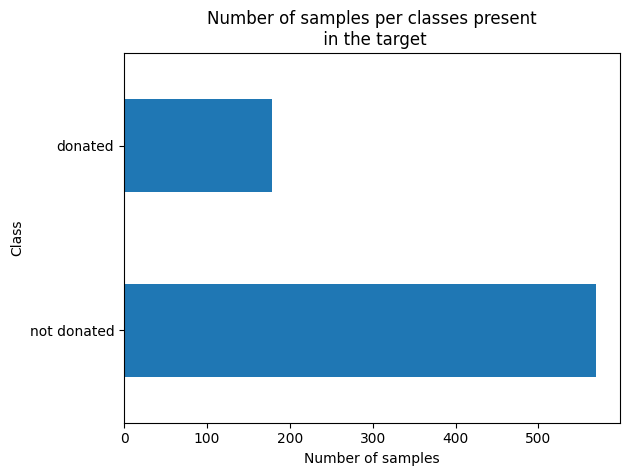

In [2]:
import matplotlib.pyplot as plt

target.value_counts().plot.barh()
plt.xlabel("Number of samples")
_ = plt.title("Number of samples per classes present\n in the target")

We can see that the vector `target` contains two classes corresponding to
whether a subject gave blood. We will use a logistic regression classifier to
predict this outcome.

To focus on the metrics presentation, we will only use a single split instead
of cross-validation.

In [3]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0, test_size=0.5)

We will use a logistic regression classifier as a base model. We will train
the model on the train set, and later use the test set to compute the
different classification metric.

In [4]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(data_train, target_train)

LogisticRegression()

## Classifier predictions
Before we go into details regarding the metrics, we will recall what type of
predictions a classifier can provide.

For this reason, we will create a synthetic sample for a new potential donor:
they donated blood twice in the past (1000 c.c. each time). The last time was
6 months ago, and the first time goes back to 20 months ago.

In [5]:
new_donor = pd.DataFrame(
    {
        "Recency": [6],
        "Frequency": [2],
        "Monetary": [1000],
        "Time": [20],
    }
)

We can get the class predicted by the classifier by calling the method
`predict`.

In [6]:
classifier.predict(new_donor)

array(['not donated'], dtype=object)

With this information, our classifier predicts that this synthetic subject
is more likely to not donate blood again.

However, we cannot check whether the prediction is correct (we do not know
the true target value). That's the purpose of the testing set. First, we
predict whether a subject will give blood with the help of the trained
classifier.

In [7]:
target_predicted = classifier.predict(data_test)
target_predicted[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

## Accuracy as a baseline
Now that we have these predictions, we can compare them with the true
predictions (sometimes called ground-truth) which we did not use until now.

In [8]:
target_test == target_predicted

258     True
521    False
14     False
31     False
505     True
       ...  
665     True
100    False
422     True
615     True
743     True
Name: Class, Length: 374, dtype: bool

In the comparison above, a `True` value means that the value predicted by our
classifier is identical to the real value, while a `False` means that our
classifier made a mistake. One way of getting an overall rate representing
the generalization performance of our classifier would be to compute how many
times our classifier was right and divide it by the number of samples in our
set.

In [9]:
import numpy as np

np.mean(target_test == target_predicted)

0.7780748663101604

This measure is called the accuracy. Here, our classifier is 78%
accurate at classifying if a subject will give blood. `scikit-learn` provides
a function that computes this metric in the module `sklearn.metrics`.

In [10]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.778


`LogisticRegression` also has a method named `score` (part of the standard
scikit-learn API), which computes the accuracy score.

In [11]:
classifier.score(data_test, target_test)

0.7780748663101604

## Confusion matrix and derived metrics
The comparison that we did above and the accuracy that we calculated did not
take into account the type of error our classifier was making. Accuracy is an
aggregate of the errors made by the classifier. We may be interested in finer
granularity - to know independently what the error is for each of the two
following cases:

- we predicted that a person will give blood but they did not;
- we predicted that a person will not give blood but they did.

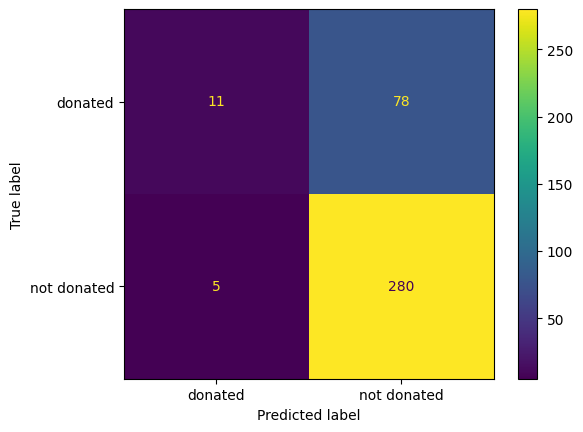

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(classifier, data_test, target_test)

The in-diagonal numbers are related to predictions that were correct
while off-diagonal numbers are related to incorrect predictions
(misclassifications). We now know the four types of correct and erroneous
predictions:

* the top left corner are true positives (TP) and corresponds to people
  who gave blood and were predicted as such by the classifier;
* the bottom right corner are true negatives (TN) and correspond to
  people who did not give blood and were predicted as such by the
  classifier;
* the top right corner are false negatives (FN) and correspond to
  people who gave blood but were predicted to not have given blood;
* the bottom left corner are false positives (FP) and correspond to
  people who did not give blood but were predicted to have given blood.

Once we have split this information, we can compute metrics to highlight the
generalization performance of our classifier in a particular setting. For
instance, we could be interested in the fraction of people who really gave
blood when the classifier predicted so or the fraction of people predicted to
have given blood out of the total population that actually did so.

The former metric, known as the precision, is defined as TP / (TP + FP)
and represents how likely the person actually gave blood when the classifier
predicted that they did.
The latter, known as the recall, defined as TP / (TP + FN) and
assesses how well the classifier is able to correctly identify people who
did give blood.
We could, similarly to accuracy, manually compute these values,
however scikit-learn provides functions to compute these statistics.

In [13]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(target_test, target_predicted, pos_label="donated")
recall = recall_score(target_test, target_predicted, pos_label="donated")

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.688
Recall score: 0.124


These results are in line with what was seen in the confusion matrix. Looking
at the left column, more than half of the "donated" predictions were correct,
leading to a precision above 0.5. However, our classifier mislabeled a lot of
people who gave blood as "not donated", leading to a very low recall of
around 0.1.

## The issue of class imbalance
At this stage, we could ask ourself a reasonable question. While the accuracy
did not look bad (i.e. 77%), the recall score is relatively low (i.e. 12%).

As we mentioned, precision and recall only focuses on samples predicted to be
positive, while accuracy takes both into account. In addition, we did not
look at the ratio of classes (labels). We could check this ratio in the
training set.

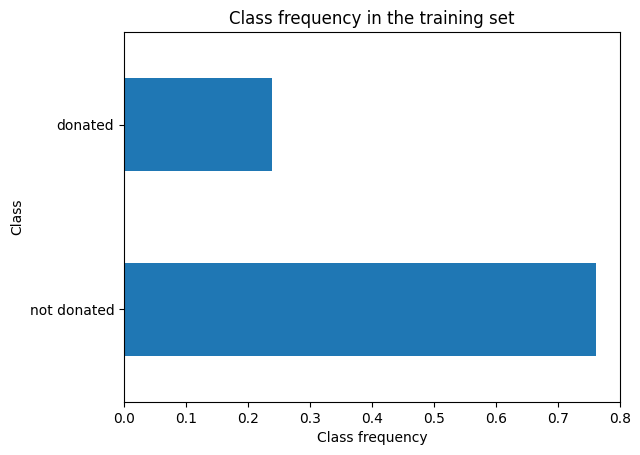

In [14]:
target_train.value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the training set")

We observe that the positive class, `'donated'`, comprises only 24% of the
samples. The good accuracy of our classifier is then linked to its ability to
correctly predict the negative class `'not donated'` which may or may not be
relevant, depending on the application. We can illustrate the issue using a
dummy classifier as a baseline.

In [15]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(data_train, target_train)
print(f"Accuracy of the dummy classifier: "
      f"{dummy_classifier.score(data_test, target_test):.3f}")

Accuracy of the dummy classifier: 0.762


With the dummy classifier, which always predicts the negative class `'not
donated'`, we obtain an accuracy score of 76%. Therefore, it means that this
classifier, without learning anything from the data `data`, is capable of
predicting as accurately as our logistic regression model.

The problem illustrated above is also known as the class imbalance problem.
When the classes are imbalanced, accuracy should not be used. In this case,
one should either use the precision and recall as presented above or the
balanced accuracy score instead of accuracy.

In [16]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)
print(f"Balanced accuracy: {balanced_accuracy:.3f}")

Balanced accuracy: 0.553


The balanced accuracy is equivalent to accuracy in the context of balanced
classes. It is defined as the average recall obtained on each class.

## Evaluation and different probability thresholds

All statistics that we presented up to now rely on `classifier.predict` which
outputs the most likely label. We haven't made use of the probability
associated with this prediction, which gives the confidence of the
classifier in this prediction. By default, the prediction of a classifier
corresponds to a threshold of 0.5 probability in a binary classification
problem. We can quickly check this relationship with the classifier that
we trained.

In [17]:
target_proba_predicted = pd.DataFrame(classifier.predict_proba(data_test),
                                      columns=classifier.classes_)
target_proba_predicted[:5]

,donated,not donated
0,0.271820,0.728180
1,0.451764,0.548236
2,0.445211,0.554789
3,0.441577,0.558423
4,0.870583,0.129417


In [18]:
target_predicted = classifier.predict(data_test)
target_predicted[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

Since probabilities sum to 1 we can get the class with the highest
probability without using the threshold 0.5.

In [19]:
equivalence_pred_proba = (
    target_proba_predicted.idxmax(axis=1).to_numpy() == target_predicted)
np.all(equivalence_pred_proba)

True

The default decision threshold (0.5) might not be the best threshold that
leads to optimal generalization performance of our classifier. In this case, one
can vary the decision threshold, and therefore the underlying prediction, and
compute the same statistics presented earlier. Usually, the two metrics
recall and precision are computed and plotted on a graph. Each metric plotted
on a graph axis and each point on the graph corresponds to a specific
decision threshold. Let's start by computing the precision-recall curve.

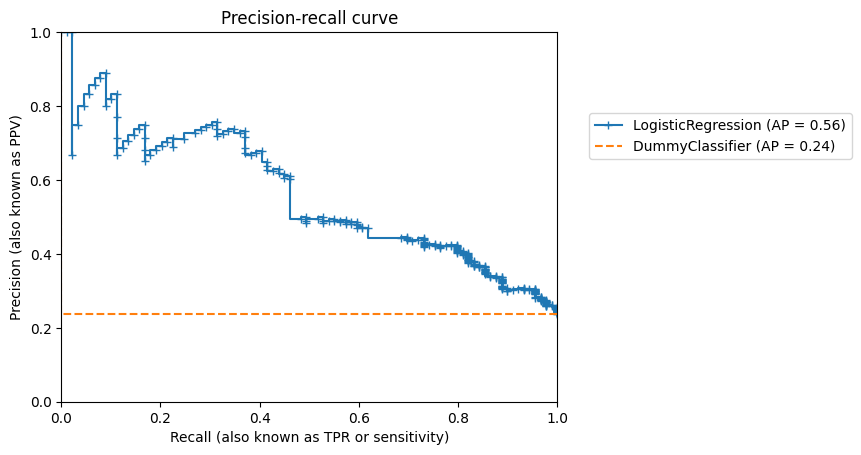

In [20]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(
    classifier, data_test, target_test, pos_label='donated',
    marker="+"
)
disp = PrecisionRecallDisplay.from_estimator(
    dummy_classifier, data_test, target_test, pos_label='donated',
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.xlabel("Recall (also known as TPR or sensitivity)")
plt.ylabel("Precision (also known as PPV)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Precision-recall curve")

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">Scikit-learn will return a display containing all plotting element. Notably,
displays will expose a matplotlib axis, named <tt class="docutils literal">ax_</tt>, that can be used to add
new element on the axis.
You can refer to the documentation to have more information regarding the
<a class="reference external" href="https://scikit-learn.org/stable/visualizations.html#visualizations">visualizations in scikit-learn</a></p>
</div>

On this curve, each blue cross corresponds to a level of probability which we
used as a decision threshold. We can see that, by varying this decision
threshold, we get different precision vs. recall values.

A perfect classifier would have a precision of 1 for all recall values. A
metric characterizing the curve is linked to the area under the curve (AUC)
and is named average precision (AP). With an ideal classifier, the average
precision would be 1.

Notice that the AP of a `DummyClassifier`, used as baseline to define the
chance level, coincides with the number of samples in the positive class
divided by the total number of samples (this number is called the prevalence
of the positive class).

In [21]:
prevalence = (
    target_test.value_counts()[1] / target_test.value_counts().sum()
)
print(f"Prevalence of the class 'donated': {prevalence:.2f}")

Prevalence of the class 'donated': 0.24


The precision and recall metric focuses on the positive class, however, one
might be interested in the compromise between accurately discriminating the
positive class and accurately discriminating the negative classes. The
statistics used for this are sensitivity and specificity. Sensitivity is just
another name for recall. However, specificity measures the proportion of
correctly classified samples in the negative class defined as: TN / (TN +
FP). Similar to the precision-recall curve, sensitivity and specificity are
generally plotted as a curve called the Receiver Operating Characteristic
(ROC) curve. Below is such a curve:

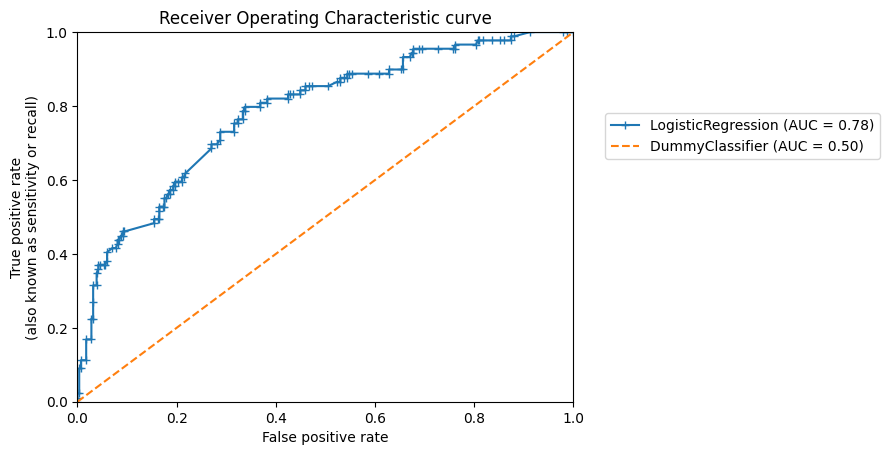

In [22]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(
    classifier, data_test, target_test, pos_label='donated',
    marker="+")
disp = RocCurveDisplay.from_estimator(
    dummy_classifier, data_test, target_test, pos_label='donated',
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate\n(also known as sensitivity or recall)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Receiver Operating Characteristic curve")

This curve was built using the same principle as the precision-recall curve:
we vary the probability threshold for determining "hard" prediction and
compute the metrics. As with the precision-recall curve, we can compute the
area under the ROC (ROC-AUC) to characterize the generalization performance of
our classifier. However, it is important to observe that the lower bound of
the ROC-AUC is 0.5. Indeed, we show the generalization performance of a dummy
classifier (the orange dashed line) to show that even the worst generalization
performance obtained will be above this line.